In [ ]:
# ===== CELDA 1: CONFIGURACIÓN Y MONTAJE =====
import os
import random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Montar Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Directorios ---
DATA_DIR = "/content/drive/MyDrive/Tyre dataset"
DEFECTIVE_DIR = os.path.join(DATA_DIR, "Defective")
GOOD_DIR      = os.path.join(DATA_DIR, "Good")

# --- Parámetros generales ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 20
SEED = 42

# --- Fijar semillas para reproducibilidad ---
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# --- Comprobar GPU ---
device_name = tf.config.list_physical_devices('GPU')
if device_name:
    print("✅ GPU detectada:", device_name[0].name)
else:
    print("⚠️ No se detectó GPU, se usará CPU.")


Mounted at /content/drive
✅ GPU detectada: /physical_device:GPU:0


In [ ]:
# ===== CELDA 2: DIVISIÓN DE DATOS =====
import glob

# Recolectar rutas de imágenes y etiquetas
image_paths = []
labels = []

for cls_name in ["Good", "Defective"]:
    folder = os.path.join(DATA_DIR, cls_name)
    imgs = glob.glob(os.path.join(folder, "*.jpg")) + \
           glob.glob(os.path.join(folder, "*.png")) + \
           glob.glob(os.path.join(folder, "*.jpeg"))
    image_paths.extend(imgs)
    labels.extend([cls_name] * len(imgs))

print(f"Total de imágenes encontradas: {len(image_paths)}")

# División 70/15/15
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.15, stratify=labels, random_state=SEED
)

val_ratio = 0.15 / 0.85
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=val_ratio, stratify=train_labels, random_state=SEED
)

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")


Total de imágenes encontradas: 1698
Train: 1188, Val: 255, Test: 255


In [ ]:
# ===== CELDA 3: DATA GENERATORS =====

# Aumentación para entrenamiento
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10
)

# Solo normalización para val/test
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Generadores desde dataframe simulado
import pandas as pd

train_df = pd.DataFrame({"filename": train_paths, "class": train_labels})
val_df   = pd.DataFrame({"filename": val_paths,   "class": val_labels})
test_df  = pd.DataFrame({"filename": test_paths,  "class": test_labels})

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_gen = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_gen = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col="filename",
    y_col="class",
    target_size=IMG_SIZE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 1188 validated image filenames belonging to 2 classes.
Found 255 validated image filenames belonging to 2 classes.
Found 255 validated image filenames belonging to 2 classes.


In [ ]:
# ===== CELDA 4: MODELO Y ENTRENAMIENTO (VERSIÓN 3 - VGG16 OPTIMIZADA) =====
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers, regularizers, callbacks
import tensorflow as tf

# --- Modelo base VGG16 ---
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))

# 🔓 Fine-tuning extendido: descongelar las últimas 8 capas convolucionales
for layer in base_model.layers[:-8]:
    layer.trainable = False
for layer in base_model.layers[-8:]:
    layer.trainable = True

print(f"Capas entrenables: {sum([l.trainable for l in base_model.layers])} / {len(base_model.layers)}")

# --- Construcción del modelo ---
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # evita sobreparametrización
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.3),
    layers.Dense(2, activation='softmax')
])

# --- Compilación ---
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),  # más bajo para fine-tuning estable
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks mejorados ---
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    callbacks.ModelCheckpoint('best_vgg16_v3.h5', monitor='val_loss', save_best_only=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-7, verbose=1)
]

# --- Entrenamiento ---
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks_list,
    verbose=1
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Capas entrenables: 8 / 19


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6431 - loss: 0.7117

75/75 ━━━━━━━━━━━━━━━━━━━━ 573s 7s/step - accuracy: 0.6445 - loss: 0.7101 - val_accuracy: 0.8667 - val_loss: 0.3661 - learning_rate: 1.0000e-05
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 63s 845ms/step - accuracy: 0.8973 - loss: 0.3566 - val_accuracy: 0.8745 - val_loss: 0.3963 - learning_rate: 1.0000e-05
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.9066 - loss: 0.3443

75/75 ━━━━━━━━━━━━━━━━━━━━ 63s 837ms/step - accuracy: 0.9067 - loss: 0.3440 - val_accuracy: 0.8902 - val_loss: 0.3370 - learning_rate: 1.0000e-05
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.9098 - loss: 0.2960

75/75 ━━━━━━━━━━━━━━━━━━━━ 64s 848ms/step - accuracy: 0.9098 - loss: 0.2961 - val_accuracy: 0.9333 - val_loss: 0.2478 - learning_rate: 1.0000e-05
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.9502 - loss: 0.2489

75/75 ━━━━━━━━━━━━━━━━━━━━ 62s 826ms/step - accuracy: 0.9501 - loss: 0.2490 - val_accuracy: 0.9412 - val_loss: 0.2292 - learning_rate: 1.0000e-05
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.9505 - loss: 0.2380

75/75 ━━━━━━━━━━━━━━━━━━━━ 64s 843ms/step - accuracy: 0.9504 - loss: 0.2382 - val_accuracy: 0.9412 - val_loss: 0.2260 - learning_rate: 1.0000e-05
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 63s 838ms/step - accuracy: 0.9590 - loss: 0.2141 - val_accuracy: 0.9451 - val_loss: 0.2368 - learning_rate: 1.0000e-05
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 63s 839ms/step - accuracy: 0.9546 - loss: 0.1967 - val_accuracy: 0.9412 - val_loss: 0.2282 - learning_rate: 1.0000e-05
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 716ms/step - accuracy: 0.9516 - loss: 0.1993

75/75 ━━━━━━━━━━━━━━━━━━━━ 63s 838ms/step - accuracy: 0.9517 - loss: 0.1992 - val_accuracy: 0.9490 - val_loss: 0.1973 - learning_rate: 1.0000e-05
Epoch 10/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 63s 832ms/step - accuracy: 0.9590 - loss: 0.1845 - val_accuracy: 0.9255 - val_loss: 0.2802 - learning_rate: 1.0000e-05
Epoch 11/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 63s 837ms/step - accuracy: 0.9754 - loss: 0.1513 - val_accuracy: 0.9294 - val_loss: 0.2503 - learning_rate: 1.0000e-05
Epoch 12/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.9789 - loss: 0.1565

75/75 ━━━━━━━━━━━━━━━━━━━━ 64s 849ms/step - accuracy: 0.9789 - loss: 0.1566 - val_accuracy: 0.9529 - val_loss: 0.1852 - learning_rate: 1.0000e-05
Epoch 13/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 62s 832ms/step - accuracy: 0.9805 - loss: 0.1356 - val_accuracy: 0.9608 - val_loss: 0.1867 - learning_rate: 1.0000e-05
Epoch 14/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 62s 824ms/step - accuracy: 0.9826 - loss: 0.1268 - val_accuracy: 0.9569 - val_loss: 0.2327 - learning_rate: 1.0000e-05
Epoch 15/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.9774 - loss: 0.1486
Epoch 15: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
75/75 ━━━━━━━━━━━━━━━━━━━━ 64s 854ms/step - accuracy: 0.9774 - loss: 0.1487 - val_accuracy: 0.9529 - val_loss: 0.2411 - learning_rate: 1.0000e-05
Epoch 16/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 64s 855ms/step - accuracy: 0.9871 - loss: 0.1178 - val_accuracy: 0.9569 - val_loss: 0.2000 - learning_rate: 3.0000e-06
Epoch 17/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 63s 845ms/step - accuracy: 0.9

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 101s 7s/step - accuracy: 0.9433 - loss: 0.2355

✅ Test Accuracy: 0.9490 | Loss: 0.2262
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 613ms/step


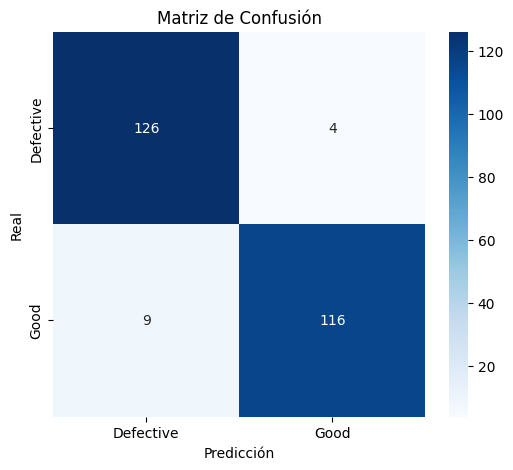


📋 Reporte de Clasificación:
              precision    recall  f1-score   support

   Defective       0.93      0.97      0.95       130
        Good       0.97      0.93      0.95       125

    accuracy                           0.95       255
   macro avg       0.95      0.95      0.95       255
weighted avg       0.95      0.95      0.95       255



In [ ]:
# ===== CELDA 5: EVALUACIÓN COMPLETA =====
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluación
test_loss, test_acc = model.evaluate(test_gen)
print(f"\n✅ Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")

# Predicciones
pred_probs = model.predict(test_gen)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Matriz de confusión
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Reporte
print("\n📋 Reporte de Clasificación:")
print(classification_report(true_classes, pred_classes, target_names=class_labels))


In [ ]:
# ===== CELDA 6: INTERFAZ CON GRADIO =====
import tensorflow as tf
import gradio as gr
from tensorflow.keras.preprocessing import image

# Cargar modelo mejor guardado
model = tf.keras.models.load_model("/content/best_vgg16_v3.h5")
class_names = list(train_gen.class_indices.keys())

def predict_tyre(img):
    img = img.convert("RGB").resize(IMG_SIZE)
    x = np.expand_dims(np.array(img) / 255.0, axis=0)
    preds = model.predict(x)[0]
    result = {class_names[i]: float(preds[i]) for i in range(len(class_names))}
    return result

iface = gr.Interface(
    fn=predict_tyre,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=2),
    title="🔍 Clasificación de Neumáticos (VGG16)",
    description="Sube una imagen de un neumático para determinar si está en buen estado o defectuoso."
)

iface.launch(debug=True)


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://790f8784d44d1a7a6a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://790f8784d44d1a7a6a.gradio.live


16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 713ms/step


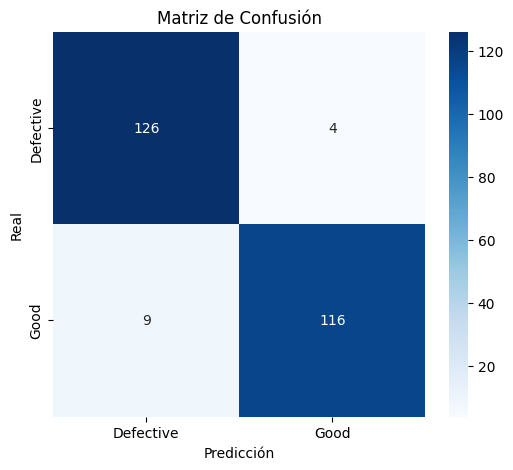

=== MÉTRICAS POR CLASE ===
              precision    recall  f1-score   support

   Defective       0.93      0.97      0.95       130
        Good       0.97      0.93      0.95       125

    accuracy                           0.95       255
   macro avg       0.95      0.95      0.95       255
weighted avg       0.95      0.95      0.95       255


✅ Ejemplos clasificados correctamente:


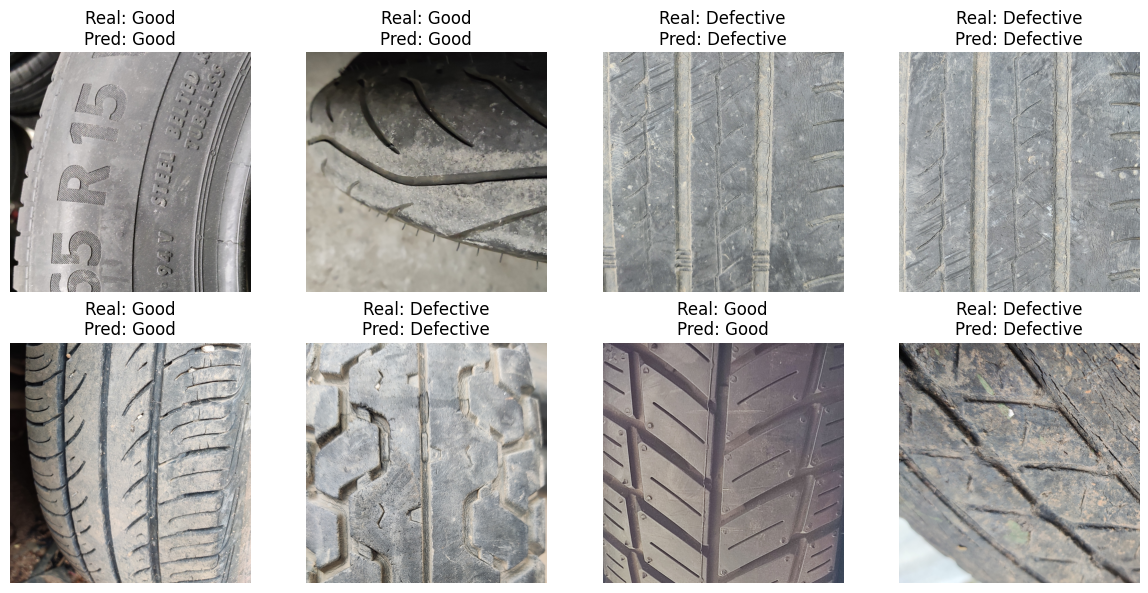


❌ Ejemplos clasificados incorrectamente:


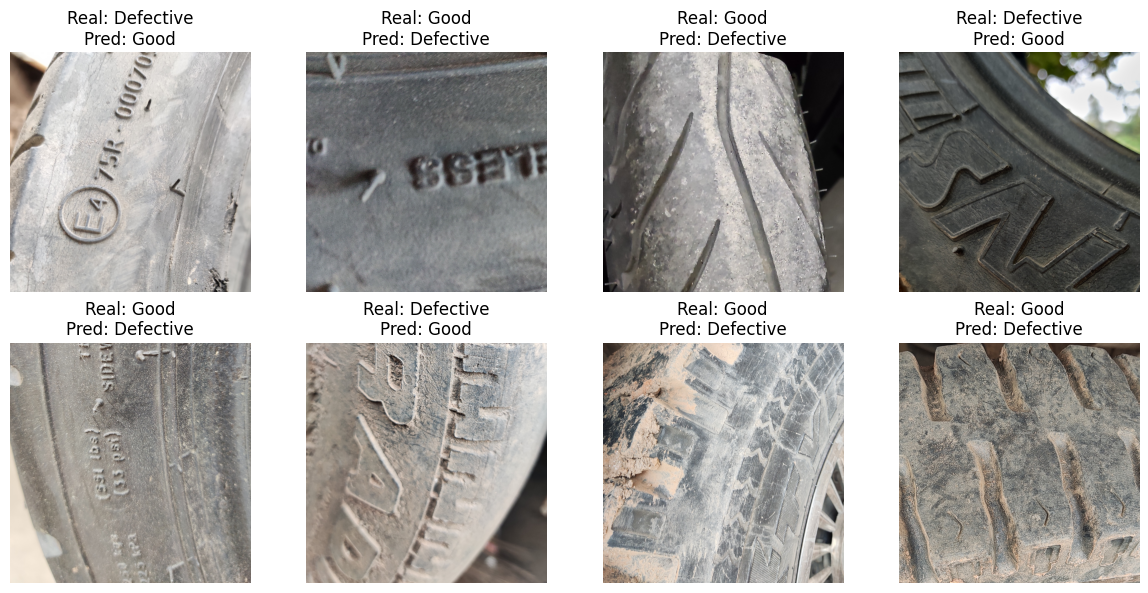

In [ ]:
# ===== CELDA 7: EVALUACIÓN AVANZADA Y VISUALIZACIÓN =====
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model

# --- Cargar mejor modelo ---
best_model = load_model("/content/best_vgg16_v3.h5")

# --- Predicciones en el conjunto de test ---
test_gen.reset()
preds = best_model.predict(test_gen, verbose=1)
pred_classes = np.argmax(preds, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# --- Matriz de confusión ---
cm = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# --- Reporte de clasificación ---
print("=== MÉTRICAS POR CLASE ===")
print(classification_report(true_classes, pred_classes, target_names=class_labels))

# --- Mostrar ejemplos correctamente y mal clasificados ---
def mostrar_resultados(test_gen, preds, class_labels, n=8):
    """Muestra ejemplos correctos e incorrectos del test set."""
    # Obtener etiquetas verdaderas y predichas
    y_true = test_gen.classes
    y_pred = np.argmax(preds, axis=1)
    filepaths = test_gen.filepaths

    # Identificar aciertos y errores
    correctos = np.where(y_true == y_pred)[0]
    errores = np.where(y_true != y_pred)[0]

    # --- Ejemplos correctos ---
    print("\n✅ Ejemplos clasificados correctamente:")
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(np.random.choice(correctos, min(n, len(correctos)), replace=False)):
        img = plt.imread(filepaths[idx])
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.title(f"Real: {class_labels[y_true[idx]]}\nPred: {class_labels[y_pred[idx]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

    # --- Ejemplos erróneos ---
    print("\n❌ Ejemplos clasificados incorrectamente:")
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(np.random.choice(errores, min(n, len(errores)), replace=False)):
        img = plt.imread(filepaths[idx])
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.title(f"Real: {class_labels[y_true[idx]]}\nPred: {class_labels[y_pred[idx]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# --- Mostrar resultados visuales ---
mostrar_resultados(test_gen, preds, class_labels, n=8)
